In [1]:
from py_files.nadadinada import cust_basket, cust_info, prod_map
from py_files.utils import plot_dendrogram, plot_elbow_graph, create_dispersion_list, create_agg_clusters, allocate_clusters

import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
cust_info.head(3)

,Unnamed: 0,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
0,0,39634,David Frink,male,05/15/1964 10:34 PM,1.0,1.0,1.0,2.0,18306.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
1,1,43460,Belinda Terry,female,03/26/1988 11:06 PM,1.0,0.0,1.0,2.0,5015.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
2,2,23937,Evelyn Calico,female,04/13/1969 06:07 PM,0.0,1.0,1.0,3.0,3097.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105


In [3]:
cust_basket.head(3)

,invoice_id,list_of_goods,customer_id
0,7448187,"['olive oil', 'yogurt cake', 'grated cheese', ...",43134
1,3167314,"['babies food', 'shower gel', 'rice', 'black b...",43134
2,10199712,"['babies food', 'barbecue sauce', 'olive oil',...",43134


In [4]:
prod_map.head(3)

,product_name,category
0,champagne,alcohol_drinks
1,bramble,alcohol_drinks
2,white wine,alcohol_drinks


For initial exploration of the clusters we need to first do some basic preprocessing: 
- alter the columns where nan values mean something
- remove nan values
- remove categorical variables
- scale data

In [5]:
cust_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43631 entries, 0 to 43630
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               43631 non-null  int64  
 1   customer_id                              43631 non-null  int64  
 2   customer_name                            43631 non-null  object 
 3   customer_gender                          43631 non-null  object 
 4   customer_birthdate                       43631 non-null  object 
 5   kids_home                                43107 non-null  float64
 6   teens_home                               42610 non-null  float64
 7   number_complaints                        42977 non-null  float64
 8   distinct_stores_visited                  42322 non-null  float64
 9   lifetime_spend_groceries                 43631 non-null  float64
 10  lifetime_spend_electronics               43631

#### Basic preprocessing explanation: 
- drop first column because it means nothing
- drop customer id, does not have business value
- drop customer name, categorical
- since bools vary the segmentation aggressively i will just remove gender as well
- i will not waste time converting birth date to age so will drop as well
- loyalty_card_number should be converted to a boolean but i will just remove it
- since latitude and longitude do not make sense to standardize and need to be analysed apart i will remove it 

In [6]:
cust_info_pp = cust_info.drop(columns=['Unnamed: 0', 'customer_id', 'customer_name', 'customer_gender',
                                       'customer_birthdate', 'loyalty_card_number', 'latitude', 'longitude'])

In [7]:
cust_info_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43631 entries, 0 to 43630
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   kids_home                                43107 non-null  float64
 1   teens_home                               42610 non-null  float64
 2   number_complaints                        42977 non-null  float64
 3   distinct_stores_visited                  42322 non-null  float64
 4   lifetime_spend_groceries                 43631 non-null  float64
 5   lifetime_spend_electronics               43631 non-null  float64
 6   typical_hour                             41886 non-null  float64
 7   lifetime_spend_vegetables                42758 non-null  float64
 8   lifetime_spend_nonalcohol_drinks         43631 non-null  float64
 9   lifetime_spend_alcohol_drinks            43631 non-null  float64
 10  lifetime_spend_meat                      43631

In [8]:
cust_info_pp.dropna(inplace=True)

In [9]:
cust_info_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36673 entries, 0 to 43630
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   kids_home                                36673 non-null  float64
 1   teens_home                               36673 non-null  float64
 2   number_complaints                        36673 non-null  float64
 3   distinct_stores_visited                  36673 non-null  float64
 4   lifetime_spend_groceries                 36673 non-null  float64
 5   lifetime_spend_electronics               36673 non-null  float64
 6   typical_hour                             36673 non-null  float64
 7   lifetime_spend_vegetables                36673 non-null  float64
 8   lifetime_spend_nonalcohol_drinks         36673 non-null  float64
 9   lifetime_spend_alcohol_drinks            36673 non-null  float64
 10  lifetime_spend_meat                      36673 non-

In [10]:
# CREATE SAMPLE DATASET TO MAKE RUN TIMES FASTER
sample_pp = cust_info_pp.sample(frac=0.1, random_state=42)

In [11]:
scaler = StandardScaler()

cust_info_pp_sc = scaler.fit_transform(cust_info_pp)
sample_pp_sc = scaler.fit_transform(sample_pp)

## Kmeans Clustering

In [12]:
# dispersion = create_dispersion_list(cust_info_pp_sc)

dispersion = create_dispersion_list(sample_pp_sc)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

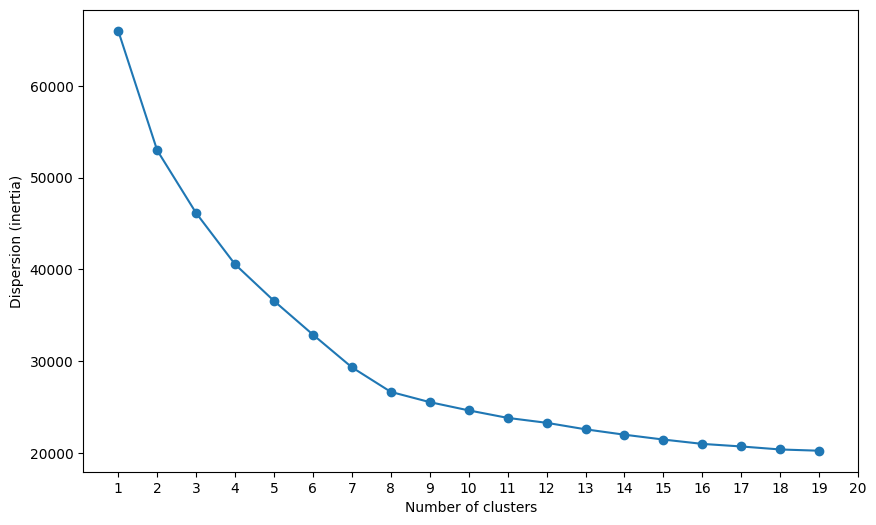

In [13]:
plot_elbow_graph(dispersion)

In this case, observing the elbow graph, we see that the dispersion decreases rapidly initially and then starts to level off. The point where this leveling off occurs, often resembling an elbow, suggests the optimal number of clusters. In the given graph, 8 seems to be a reasonable number of clusters as it corresponds to the point where the decrease in dispersion significantly slows down, indicating diminishing returns in clustering quality beyond this point. Therefore, based on the elbow method, 8 clusters appear to be a suitable choice for this dataset.

In [14]:
# allocate_clusters(cust_info_pp, cust_info_pp_sc, n_clusters=8, cluster_type='KMeans')
allocate_clusters(sample_pp, sample_pp_sc, n_clusters=8, cluster_type='KMeans')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
st = 'KMeans'
st.lower()

'kmeans'

In [16]:
sample_pp

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,cluster_kmeans
32174,1.0,0.0,1.0,1.0,3932.0,332.0,9.0,149.0,812.0,1575.0,725.0,2079.0,1924.0,869.0,1560.0,1608.0,0.195728,2010.0,4
24009,2.0,1.0,1.0,2.0,4454.0,3148.0,18.0,462.0,551.0,445.0,1192.0,1187.0,678.0,1090.0,1056.0,82.0,0.151540,2007.0,3
38186,1.0,1.0,0.0,2.0,892.0,549.0,17.0,904.0,870.0,910.0,744.0,499.0,300.0,521.0,514.0,41.0,-0.100004,2007.0,0
27250,1.0,1.0,1.0,3.0,2003.0,272.0,15.0,233.0,264.0,175.0,601.0,339.0,358.0,526.0,928.0,339.0,0.594341,2016.0,2
30806,1.0,0.0,1.0,1.0,2738.0,689.0,11.0,1249.0,250.0,9.0,1.0,0.0,417.0,238.0,597.0,226.0,0.193813,2012.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,1.0,2.0,1.0,3.0,1964.0,315.0,16.0,228.0,342.0,358.0,584.0,248.0,374.0,493.0,573.0,623.0,0.496743,2012.0,2
30310,0.0,1.0,1.0,2.0,3995.0,4562.0,11.0,315.0,536.0,45.0,516.0,2346.0,2324.0,1312.0,2104.0,932.0,0.280473,2010.0,4
16939,2.0,3.0,1.0,1.0,5206.0,2997.0,9.0,549.0,493.0,212.0,1615.0,780.0,893.0,961.0,793.0,345.0,-0.088416,2005.0,3
9826,1.0,1.0,0.0,1.0,17428.0,1585.0,12.0,545.0,701.0,1321.0,2679.0,3663.0,2074.0,4721.0,3443.0,207.0,0.045707,2017.0,1


In [17]:
# cust_info_pp.groupby(['cluster_kmeans']).mean()
sample_pp.groupby(['cluster_kmeans']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction
cluster_kmeans,,,,,,,,,,,,,,,,,,
0,1.000000,0.483728,0.542899,1.227811,2902.778107,429.124260,13.729290,984.642012,321.738166,171.295858,77.701183,79.313609,508.871302,239.480769,507.196746,220.460059,0.203176,2011.004438
1,1.001905,1.000000,0.499048,1.432381,13873.830476,8094.043810,13.580952,490.954286,598.548571,1038.327619,1990.000000,4008.569524,1991.780952,3975.758095,2981.209524,101.333333,0.042105,2011.205714
2,0.566176,0.994118,0.957353,2.966176,2052.307353,238.029412,12.433824,216.000000,315.710294,323.726471,424.804412,497.783824,486.260294,389.451471,605.072059,395.095588,0.481397,2010.805882
3,3.166038,2.037736,0.960377,1.118868,4989.722642,1933.062264,17.716981,500.271698,516.116981,312.667925,1036.050943,1006.001887,981.858491,1010.575472,996.549057,494.515094,0.198939,2010.973585
4,1.036697,0.832569,1.084862,1.979358,4857.722477,2026.337156,9.504587,316.525229,617.873853,976.981651,972.846330,1851.743119,1885.442661,946.864679,1863.022936,995.215596,0.197074,2008.465596
5,0.000000,0.016260,0.471545,1.000000,9956.149051,158.647696,11.907859,195.065041,503.642276,40.070461,195.883469,212.102981,75.452575,0.000000,9936.764228,50.848238,0.195482,2011.048780
6,0.000000,0.083333,0.583333,1.000000,13912.722222,184.138889,10.444444,356.694444,310.666667,96.222222,102.472222,40073.722222,91.527778,0.000000,0.000000,20.583333,0.388960,2011.250000
7,0.438554,0.204819,0.163855,1.561446,3252.481928,2085.137349,15.103614,261.440964,402.216867,843.539759,554.971084,685.884337,617.650602,698.901205,583.132530,375.269880,0.162595,2016.693976


In [18]:
# cust_info_pp.mean()
sample_pp.mean()

kids_home                                     1.063267
teens_home                                    0.835833
number_complaints                             0.688574
distinct_stores_visited                       1.665667
lifetime_spend_groceries                   5707.277066
lifetime_spend_electronics                 2056.130079
typical_hour                                 13.481865
lifetime_spend_vegetables                   454.517589
lifetime_spend_nonalcohol_drinks            450.858740
lifetime_spend_alcohol_drinks               502.058631
lifetime_spend_meat                         726.941369
lifetime_spend_fish                        1538.781293
lifetime_spend_hygiene                      913.618489
lifetime_spend_videogames                  1023.308154
lifetime_spend_petfood                     2063.966185
lifetime_total_distinct_products            366.005999
percentage_of_products_bought_promotion       0.226827
year_first_transaction                     2011.340878
cluster_km

Note: It is **very** important to compare clusters against the mean of the variables and not their relative difference in between clusters. The mean (or any other centrality measure) of the variable will give us an "anchor" that we can use when explaining why a certain "cluster" has a certain set of characteristics.

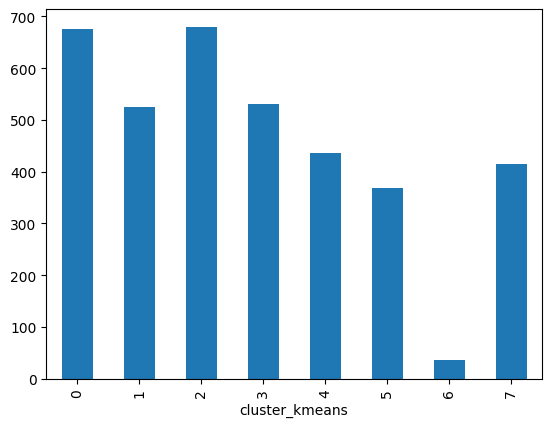

In [19]:
# cust_info_pp.groupby(['cluster_kmeans']).size().plot(kind='bar')
sample_pp.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()

## Hierarchical Clustering

In [20]:
# por isto em funcao 
# agg_clust = create_agg_clusters(cust_info_pp_sc)
agg_clust = create_agg_clusters(sample_pp_sc)

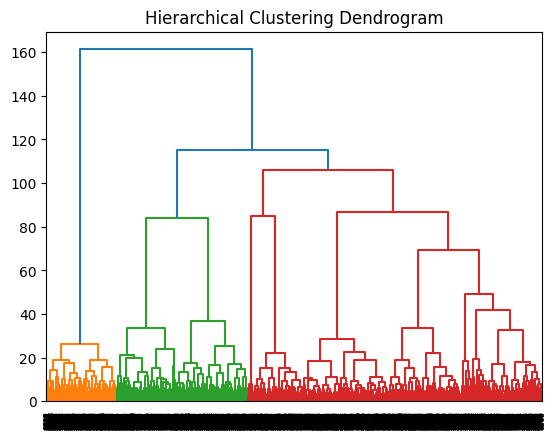

In [21]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.show()

We can notice that outliers are still present in the dataset because some clusters have very few points.

On the right clusters should be further analysed in order to understand if they are similiar (if so join in one) or different (mantain separate)

I will cut around the y=200 making the solution 8 clusters to be able to compare it with the k-means.

In [22]:
# allocate_clusters(cust_info_pp, cust_info_pp_sc, n_clusters=8, cluster_type='AgglomerativeClustering')
allocate_clusters(sample_pp, sample_pp_sc, n_clusters=8, cluster_type='AgglomerativeClustering')

In [23]:
AgglomerativeClustering()

AgglomerativeClustering()

In [24]:
# cust_info_pp.head()
sample_pp.head()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,cluster_kmeans,cluster_hierarchical
32174,1.0,0.0,1.0,1.0,3932.0,332.0,9.0,149.0,812.0,1575.0,725.0,2079.0,1924.0,869.0,1560.0,1608.0,0.195728,2010.0,4,2
24009,2.0,1.0,1.0,2.0,4454.0,3148.0,18.0,462.0,551.0,445.0,1192.0,1187.0,678.0,1090.0,1056.0,82.0,0.151540,2007.0,3,1
38186,1.0,1.0,0.0,2.0,892.0,549.0,17.0,904.0,870.0,910.0,744.0,499.0,300.0,521.0,514.0,41.0,-0.100004,2007.0,0,0
27250,1.0,1.0,1.0,3.0,2003.0,272.0,15.0,233.0,264.0,175.0,601.0,339.0,358.0,526.0,928.0,339.0,0.594341,2016.0,2,3
30806,1.0,0.0,1.0,1.0,2738.0,689.0,11.0,1249.0,250.0,9.0,1.0,0.0,417.0,238.0,597.0,226.0,0.193813,2012.0,0,4


In [25]:
# cust_info_pp.groupby(['cluster_hierarchical']).mean()
sample_pp.groupby(['cluster_hierarchical']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,cluster_kmeans
cluster_hierarchical,,,,,,,,,,,,,,,,,,,
0,0.510851,0.480801,0.337229,1.782972,2728.519199,1486.824708,14.380634,315.799666,429.242070,712.545910,523.803005,607.272120,548.754591,597.818030,557.343907,375.165275,0.191901,2014.429048,5.148581
1,3.139665,1.983240,0.951583,1.098696,5073.864060,1981.644320,17.677840,496.728119,509.182495,302.350093,1040.962756,1020.100559,988.251397,1016.668529,1003.184358,502.452514,0.200029,2011.048417,3.078212
2,1.046296,0.835648,1.111111,1.962963,4944.481481,2062.432870,9.592593,309.995370,588.738426,1002.932870,972.039352,1876.958333,1910.650463,960.138889,1893.287037,992.261574,0.201740,2008.625000,4.002315
3,0.559041,0.987085,0.998155,3.149446,2053.488930,216.136531,12.378229,208.105166,308.990775,307.081181,409.470480,498.055351,487.448339,385.202952,602.964945,396.435424,0.525052,2010.976015,2.009225
4,1.000000,0.450479,0.533546,1.177316,2967.186901,419.099042,13.686901,992.530351,302.132588,141.642173,48.031949,39.731629,518.049521,219.798722,506.105431,209.774760,0.206555,2011.105431,0.059105
5,0.000000,0.083333,0.583333,1.000000,13912.722222,184.138889,10.444444,356.694444,310.666667,96.222222,102.472222,40073.722222,91.527778,0.000000,0.000000,20.583333,0.388960,2011.250000,6.000000
6,0.000000,0.016216,0.470270,1.000000,9941.762162,158.386486,11.902703,195.086486,503.748649,40.305405,196.156757,211.740541,75.586486,0.000000,9917.137838,50.859459,0.195328,2011.070270,5.005405
7,1.001905,1.000000,0.499048,1.432381,13873.830476,8094.043810,13.580952,490.954286,598.548571,1038.327619,1990.000000,4008.569524,1991.780952,3975.758095,2981.209524,101.333333,0.042105,2011.205714,1.000000


In [26]:
# cust_info_pp.mean()
sample_pp.mean()

kids_home                                     1.063267
teens_home                                    0.835833
number_complaints                             0.688574
distinct_stores_visited                       1.665667
lifetime_spend_groceries                   5707.277066
lifetime_spend_electronics                 2056.130079
typical_hour                                 13.481865
lifetime_spend_vegetables                   454.517589
lifetime_spend_nonalcohol_drinks            450.858740
lifetime_spend_alcohol_drinks               502.058631
lifetime_spend_meat                         726.941369
lifetime_spend_fish                        1538.781293
lifetime_spend_hygiene                      913.618489
lifetime_spend_videogames                  1023.308154
lifetime_spend_petfood                     2063.966185
lifetime_total_distinct_products            366.005999
percentage_of_products_bought_promotion       0.226827
year_first_transaction                     2011.340878
cluster_km

In [27]:
# Starting with the Ward vs. k-means:
'''pd.DataFrame(
    confusion_matrix(cust_info_pp.cluster_kmeans, cust_info_pp.cluster_hierarchical),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,8)],
    columns = ['Ward {} Cluster'.format(i) for i in np.arange(0,8)],
)'''
pd.DataFrame(
    confusion_matrix(sample_pp.cluster_kmeans, sample_pp.cluster_hierarchical),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,8)],
    columns = ['Ward {} Cluster'.format(i) for i in np.arange(0,8)],
)

,Ward 0 Cluster,Ward 1 Cluster,Ward 2 Cluster,Ward 3 Cluster,Ward 4 Cluster,Ward 5 Cluster,Ward 6 Cluster,Ward 7 Cluster
K-means 0 Cluster,48,5,3,0,620,0,0,0
K-means 1 Cluster,0,0,0,0,0,0,0,525
K-means 2 Cluster,133,0,5,541,1,0,0,0
K-means 3 Cluster,12,514,4,0,0,0,0,0
K-means 4 Cluster,20,5,411,0,0,0,0,0
K-means 5 Cluster,0,0,0,0,0,0,369,0
K-means 6 Cluster,0,0,0,0,0,36,0,0
K-means 7 Cluster,386,13,9,1,5,0,1,0


We can see some similarities within clusters:
- Cluster 0 in kmeans is very simmilar to cluster 4 in hierarchical
- Cluster 1 in kmeans is simmilar to cluster 3 in hierarchical
- Cluster 2 in kmeans is simmilar to cluster 3 in hierarchical
- Cluster 3 in kmeans is very dispersed (divided into 1, 2 and 6)
- Cluster 4 in kmeans is divided into cluster 3 and 4 from hierachical
- Cluster 5 in kmeans is divided into cluster 0 and 7 from hierachical
- Cluster 6 in kmeans is very simmilar to cluster 4 in hierarchical
- Cluster 7 in kmeans only has values from cluster 5 in hierarchical but only 330 records